<img src="../img/snowflake-logo.png"  width="200" height="50">

<img src="../img/2560px-NTT-Data-Logo.svg.png"  width="150" height="30"> 


# Snowpark Machine Learning Demo

![Snowflake](../img/pipeline1.png)

In [1]:
import snowflake.snowpark
from snowflake.snowpark.types import Variant
from snowflake.snowpark.session import Session
from snowflake.snowpark.functions import sproc, udf, substr, max, min, sum, length, regexp_replace, call_udf, array_construct, col
from pandas.plotting import scatter_matrix
from matplotlib import pyplot as plt
import matplotlib
import cachetools
import json
import io
import os
import numpy as np
%matplotlib inline

#### Snowpark session

In [2]:
connection_params = json.load(open('connection_params.json'))
session = Session.builder.configs(connection_params).create()
session.add_packages('snowflake-snowpark-python', 'scikit-learn', 'pandas', 'numpy', 'joblib', 'cachetools')

In [ ]:
#session.close()

#### Checking the connection with the Snowflake environment

In [3]:
print(session.sql("select current_warehouse(), current_database(), current_schema()").collect())

[Row(CURRENT_WAREHOUSE()='COMPUTE_WH', CURRENT_DATABASE()='SNOWPARK_DEMO', CURRENT_SCHEMA()='ML')]


<img src="../img/pipeline21.png"  width="900" height="350">

**Preparation:** 
- All calculations and tranformations
- Feature engineering

**Advantages:** 
- Snowflake as single source of data
- External datasets can be easily added as external stages

#### About the metrics
**hospitalCases:** Patients in hospital - Daily numbers of confirmed COVID-19 patients in hospital.\
**newAdmissions:** Daily number of new admissions to hospital of patients with COVID-19. \
Source: https://coronavirus.data.gov.uk/metrics/

In [4]:
session.read.table("RAW_JSON_NHS").show()


-------------------------------------------------
|"RAW_FILE"                                     |
-------------------------------------------------
|{                                              |
|  "body": [                                    |
|    {                                          |
|      "areaCode": "E40000008",                 |
|      "areaName": "Midlands",                  |
|      "areaType": "nhsRegion",                 |
|      "date": "2022-09-07",                    |
|      "hospitalCases": 963,                    |
|      "newAdmissions": null                    |
|    },                                         |
|    {                                          |
|      "areaCode": "E40000008",                 |
|      "areaName": "Midlands",                  |
|      "areaType": "nhsRegion",                 |
|      "date": "2022-09-06",                    |
|      "hospitalCases": 971,                    |
|      "newAdmissions": null                    |


In [5]:
df_nhs_covid = session.sql("SELECT value:areaCode::STRING as area_code," \
                                   "value:areaName::STRING as area_name," \
                                   "value:date::DATE as day_date," \
                                   "value:hospitalCases::INT as num_hospital_cases," \
                                   "value:newAdmissions::INT as num_admissions " \
                           "FROM SNOWPARK_DEMO.ML.RAW_JSON_NHS, LATERAL FLATTEN( INPUT => raw_file:body )")

In [6]:
df_nhs_covid.show()

------------------------------------------------------------------------------------
|"AREA_CODE"  |"AREA_NAME"  |"DAY_DATE"  |"NUM_HOSPITAL_CASES"  |"NUM_ADMISSIONS"  |
------------------------------------------------------------------------------------
|E40000008    |Midlands     |2022-09-07  |963                   |NULL              |
|E40000008    |Midlands     |2022-09-06  |971                   |NULL              |
|E40000008    |Midlands     |2022-09-05  |1002                  |127               |
|E40000008    |Midlands     |2022-09-04  |988                   |105               |
|E40000008    |Midlands     |2022-09-03  |976                   |114               |
|E40000008    |Midlands     |2022-09-02  |986                   |131               |
|E40000008    |Midlands     |2022-09-01  |1005                  |124               |
|E40000008    |Midlands     |2022-08-31  |1005                  |129               |
|E40000008    |Midlands     |2022-08-30  |988                   |

#### Data transformations

In [7]:
df_nhs_covid_month = df_nhs_covid.withColumn('month_year', regexp_replace(substr(df_nhs_covid.DAY_DATE, 0, 7), '-', ''))
df_nhs_covid_month = df_nhs_covid_month.dropna()
df_nhs_covid_month = df_nhs_covid_month.withColumn('N_AREA_CODE', substr(df_nhs_covid.AREA_CODE, 2, length(df_nhs_covid.AREA_CODE)))

In [8]:
df_nhs_covid_month.show()

-------------------------------------------------------------------------------------------------------------------
|"AREA_CODE"  |"AREA_NAME"  |"DAY_DATE"  |"NUM_HOSPITAL_CASES"  |"NUM_ADMISSIONS"  |"MONTH_YEAR"  |"N_AREA_CODE"  |
-------------------------------------------------------------------------------------------------------------------
|E40000008    |Midlands     |2022-09-05  |1002                  |127               |202209        |40000008       |
|E40000008    |Midlands     |2022-09-04  |988                   |105               |202209        |40000008       |
|E40000008    |Midlands     |2022-09-03  |976                   |114               |202209        |40000008       |
|E40000008    |Midlands     |2022-09-02  |986                   |131               |202209        |40000008       |
|E40000008    |Midlands     |2022-09-01  |1005                  |124               |202209        |40000008       |
|E40000008    |Midlands     |2022-08-31  |1005                  |129    

##### Saving Dataframe as a new table within the Snowflake database

In [10]:
df_nhs_covid_month.write.mode('overwrite').save_as_table('NHS_COVID')

In [11]:
df_covid_nhs = session.read.table('NHS_COVID')
df_nhs_covid_prep = df_covid_nhs.drop('AREA_CODE').withColumnRenamed('N_AREA_CODE', 'AREA_CODE').select('MONTH_YEAR','AREA_CODE', 'NUM_HOSPITAL_CASES', 'NUM_ADMISSIONS')
df_nhs_covid_prep = df_nhs_covid_prep.groupBy(df_nhs_covid_prep.MONTH_YEAR, df_nhs_covid_prep.AREA_CODE).sum(df_nhs_covid_prep.NUM_HOSPITAL_CASES, df_nhs_covid_prep.NUM_ADMISSIONS) \
                                                                                                        .withColumnRenamed('SUM(NUM_ADMISSIONS)', 'NUM_ADMISSIONS') \
                                                                                                        .withColumnRenamed('SUM(NUM_HOSPITAL_CASES)', 'HOSPITAL_CASES')

In [12]:
df_nhs_covid_prep.show()

--------------------------------------------------------------------
|"MONTH_YEAR"  |"AREA_CODE"  |"HOSPITAL_CASES"  |"NUM_ADMISSIONS"  |
--------------------------------------------------------------------
|202209        |40000008     |4957              |601               |
|202208        |40000008     |45232             |5128              |
|202207        |40000008     |74821             |9802              |
|202206        |40000008     |29523             |5126              |
|202205        |40000008     |38240             |3549              |
|202204        |40000008     |86489             |9235              |
|202203        |40000008     |60931             |9178              |
|202202        |40000008     |54196             |5577              |
|202201        |40000008     |87097             |10661             |
|202111        |40000008     |37205             |4109              |
--------------------------------------------------------------------



##### Saving Dataframe for the model training

In [13]:
df_nhs_covid_prep.write.mode('overwrite').save_as_table('NHS_COVID_PREP')

<img src="../img/pipeline22.png"  width="900" height="350">

## Exploratory Analysis

In [14]:
df_covid_nhs = session.read.table('NHS_COVID_PREP')

In [16]:
df_covid_nhs.describe().show()

------------------------------------------------------------------------------------
|"SUMMARY"  |"MONTH_YEAR"  |"AREA_CODE"  |"HOSPITAL_CASES"    |"NUM_ADMISSIONS"    |
------------------------------------------------------------------------------------
|count      |217           |217          |217.0               |217.0               |
|mean       |NULL          |NULL         |34270.815668        |3898.990783         |
|stddev     |NULL          |NULL         |32750.716513834745  |3509.5605573162575  |
|min        |202003        |40000003     |588.0               |76.0                |
|max        |202209        |40000010     |217579.0            |21168.0             |
------------------------------------------------------------------------------------



##### Boxplot view

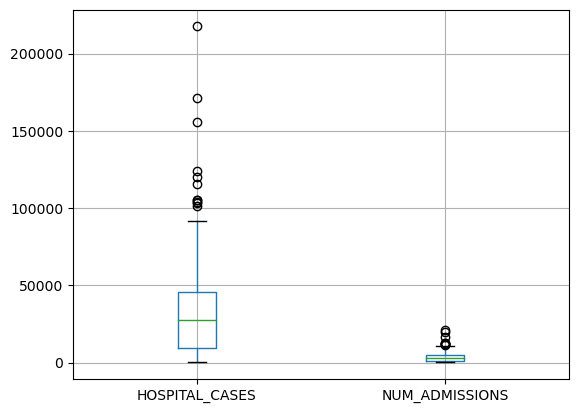

In [17]:
df_covid_nhs.toPandas().boxplot(column=['HOSPITAL_CASES', 'NUM_ADMISSIONS'])

##### Variable correlation and distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd4e1122a60>,
      dtype=object)

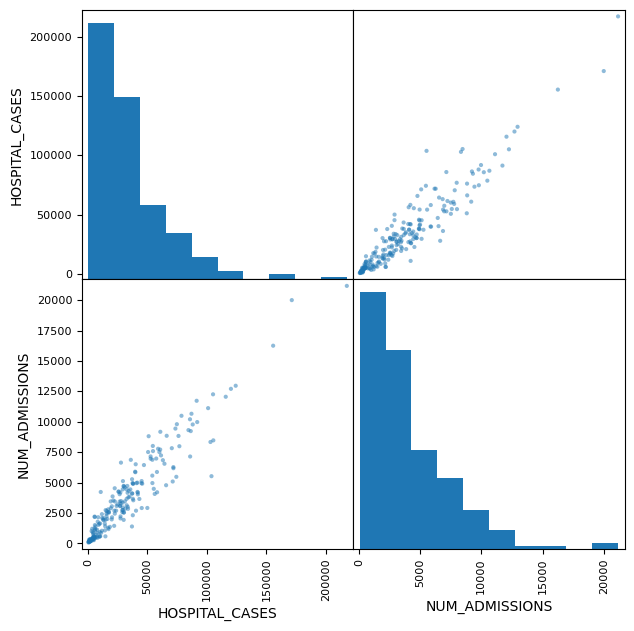

In [18]:
scatter_matrix(df_covid_nhs.toPandas(), figsize=(7,7), diagonal='hist')

##### Model training

In [19]:
def save_file(session, model):
    import joblib
    import os
    
    model_output_dir = '/tmp'
    model_file = os.path.join(model_output_dir, 'model.joblib')
    joblib.dump(model, model_file)
    session.file.put(model_file, '@MODELS', overwrite=True)

In [20]:
def train_model(session: snowflake.snowpark.Session) -> Variant:

    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error
    from sklearn.preprocessing import StandardScaler
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import Pipeline
    from sklearn.compose import ColumnTransformer
    
    df_covid_nhs_pd = session.read.table('NHS_COVID_PREP').to_pandas()
    
    X = df_covid_nhs_pd.drop("HOSPITAL_CASES", axis = 1)
    Y = df_covid_nhs_pd["HOSPITAL_CASES"]
    
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.15, random_state=42)


    # FEATURE ENGINEERING
    num_attribs = list(X)
    
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler())
    ])
    
    preprocessor = ColumnTransformer([
            ("num", num_pipeline, num_attribs)
        ])

    full_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', RandomForestRegressor(n_estimators=9000, random_state=82, max_depth=100))
        ])

    # fit the preprocessing pipeline and the model together
    full_pipeline.fit(X_train, y_train)
    
    save_file(session, full_pipeline)

    predicted = full_pipeline.predict(X_test)
    lin_mse = mean_squared_error(y_test, predicted)
    lin_rmse=np.sqrt(lin_mse)

    return lin_rmse


##### Model Deployment

<img src="../img/pipeline23.png"  width="900" height="350">

##### Register the training function as Store Procedure

In [21]:
session.add_packages('snowflake-snowpark-python')
session.sproc.register(func=train_model, name='train_model_sp', replace=True, packages=['snowflake-snowpark-python', 'scikit-learn', 'pandas', 'numpy', 'joblib', 'cachetools'])

In [23]:
print(session.call('train_model_sp'))

8948.049277859247


In [24]:
@cachetools.cached(cache={})
def read_file(filename):
    import sys
    import cachetools
    import os
    import joblib
    
    import_dir = sys._xoptions.get("snowflake_import_directory")
    
    if import_dir:
        with open(os.path.join(import_dir, filename), 'rb') as file:
            m = joblib.load(file)
            return m

In [25]:
session.clear_imports()
session.clear_packages()
session.add_import('@MODELS/model.joblib.gz')

@udf(name="predict_hospitals", session=session, packages=['snowflake-snowpark-python', 'scikit-learn', 'pandas', 'numpy', 'joblib', 'cachetools'], is_permanent=True, stage_location="@MODELS", replace=True)

def predict_hospitals(fields:list) -> float:
    import sys
    import cachetools
    import pandas as pd
    from joblib import load
    
    features = ['MONTH_YEAR','AREA_CODE','NUM_ADMISSIONS']
    
    m = read_file('model.joblib.gz')
    
    #row = pd.DataFrame([locals()], columns=features)
    row = pd.DataFrame([fields], columns=features)
    return m.predict(row)[0]

<img src="../img/pipeline5.png">

In [26]:
test_df = session.createDataFrame([[202210, 40000008, 100], [202211, 40000008, 150], [202212, 40000008, 80]], schema=['MONTH_YEAR','AREA_CODE','NUM_ADMISSIONS'])

In [27]:
test_df.select('MONTH_YEAR','AREA_CODE','NUM_ADMISSIONS', call_udf('predict_hospitals', array_construct(col('MONTH_YEAR'), col('AREA_CODE'), col('NUM_ADMISSIONS'))).alias('PREDICTED_HOSPITAL_CASES')).show()

------------------------------------------------------------------------------
|"MONTH_YEAR"  |"AREA_CODE"  |"NUM_ADMISSIONS"  |"PREDICTED_HOSPITAL_CASES"  |
------------------------------------------------------------------------------
|202211        |40000008     |150               |2297.793222222222           |
|202210        |40000008     |100               |2252.1314444444442          |
|202212        |40000008     |80                |2240.7366666666667          |
------------------------------------------------------------------------------

